## I’m Something of a Painter Myself Project

This project covers the Kaggle intoduction to GAN models, especially CycleGAN. The CycleGAN is an extension of the GAN architecture that involves the simultaneous training of two generator models and two discriminator models, its mainly used for style transfer in this project.

One generator takes images from the first domain as input and outputs images for the second domain, and the other generator takes images from the second domain as input and generates images for the first domain. Discriminator models are then used to determine how plausible the generated images are and update the generator models accordingly. In essence CycleGANs are extended architecture over the simple GAN.

In the course we were taught general GANs only, old assignment also covered simple GANs where we create One Generator and one Discriminator based Deep Convolutional Generative Adversarial Network. However since this assignment covers the topics not covered in the course we have accessed various blogposts, videos, and Kaggle introductry notebooks to create this project.

Dataset is based on the Kaggle I’m Something of a Painter Myself competition: https://www.kaggle.com/competitions/gan-getting-started

We are tasked to create a CycleGAN which is able to apply transfer learning and transfer the monet style to non monet styled images.

We are given 300 Monet Images and 7038 Other images. In the submission we will submit the monet converted images to the Kaggle competition.

This project is broken down into following parts:
1. Packages
2. EDA
3. Model Creation
4. Model Fitting and Hyperparameter Tuning
5. Model Evaluation
6. Conclusion

## 1. Packages

In [2]:
import os
import cv2

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as tfl
import tensorflow_addons as tfa

AUTOTUNE = tf.data.experimental.AUTOTUNE

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import image as Image

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

from kaggle_datasets import KaggleDatasets
import warnings
warnings.simplefilter('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

Number of replicas: 1


/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## 2. EDA

This dataset has been already cleaned and tidied. We have also assumed that all the monet images are indeed monet images and not other type of images.

Now we will load the datasets and perform basic EDA by looking through the images among other things.

In [3]:
path = KaggleDatasets().get_gcs_path()

In [4]:
#We have been given .tfrec files and jpeg, for the project we will use .tfrec files

monet_filenames = tf.io.gfile.glob(str(path + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(monet_filenames))

photo_filenames = tf.io.gfile.glob(str(path + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(monet_filenames))

Monet TFRecord Files: 5
Photo TFRecord Files: 5


In [5]:
monet_filenames[0]

'gs://kds-b6ce43e99b5bd07e2756e7ea6ced98b6b647a72523abac4d874dc36c/monet_tfrec/monet00-60.tfrec'

Now we will look through a random Monet image from the jpeg folder.

(256, 256, 3)


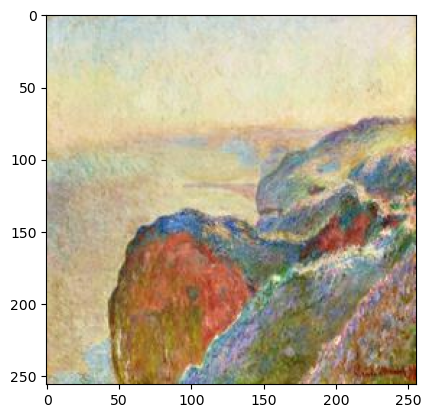

In [6]:
image_monet = Image.imread('/kaggle/input/gan-getting-started/monet_jpg/000c1e3bff.jpg')
print(image_monet.shape)
plt.imshow(image_monet)
plt.show()

Now, we will look at a random others images.

(256, 256, 3)


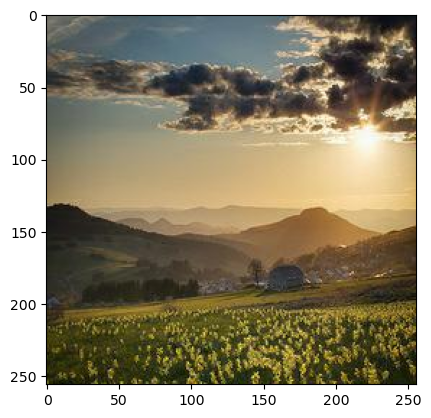

In [7]:
image_others = Image.imread('/kaggle/input/gan-getting-started/photo_jpg/00068bc07f.jpg')
print(image_others.shape)
plt.imshow(image_others)
plt.show()

As we can see from above Monet Image can be easily be identified as painted image while other images are captured via camera, we will create a CycleGAN which will convert the non monet images into monet images. Many photoshop tools like Luminar AI actually uses more advanced transfer learning model to do similar things.

In [8]:
monet_jpg_filepath = "../input/gan-getting-started/monet_jpg"
photo_jpg_filepath = "../input/gan-getting-started/photo_jpg"

In [9]:
monet_image_paths = []
for dirname, _, filenames in os.walk(monet_jpg_filepath):
    for filename in filenames:
        fullpath = os.path.join(dirname, filename)
        monet_image_paths.append(fullpath)
monet_image_paths[:2]

['../input/gan-getting-started/monet_jpg/f4413e97bd.jpg',
 '../input/gan-getting-started/monet_jpg/7341d96c1d.jpg']

In [10]:
others_image_paths = []
for dirname, _, filenames in os.walk(photo_jpg_filepath):
    for filename in filenames:
        fullpath = os.path.join(dirname, filename)
        others_image_paths.append(fullpath)
others_image_paths[:2]

['../input/gan-getting-started/photo_jpg/fb97febc5f.jpg',
 '../input/gan-getting-started/photo_jpg/c54c5368af.jpg']

In [11]:
print('Number of Other Images:', len(others_image_paths))

Number of Other Images: 7038


In [12]:
print('Number of Monet Images:', len(others_image_paths))

Number of Monet Images: 7038


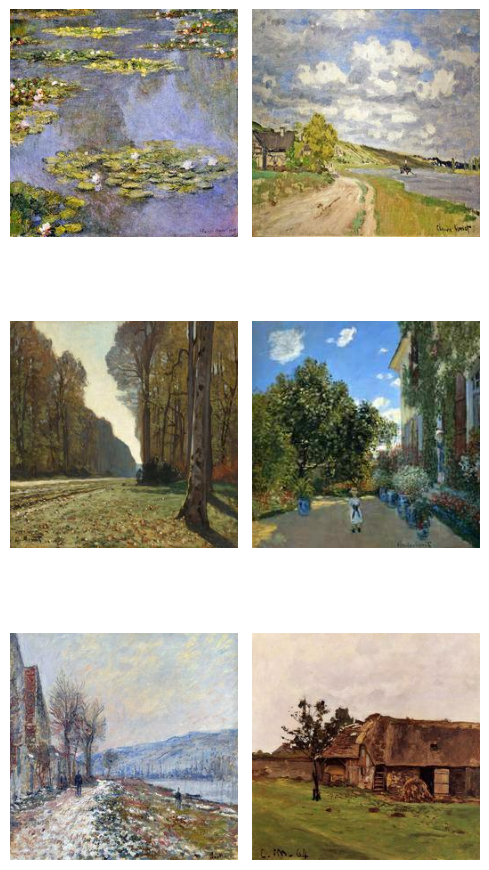

In [13]:
figure, ax = plt.subplots(nrows = 3,ncols = 2,figsize=(5,10))
for i, image_path in enumerate(monet_image_paths):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    try:
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    except:
        continue;
        
plt.tight_layout()
plt.show()

Here we have some more monet images above.

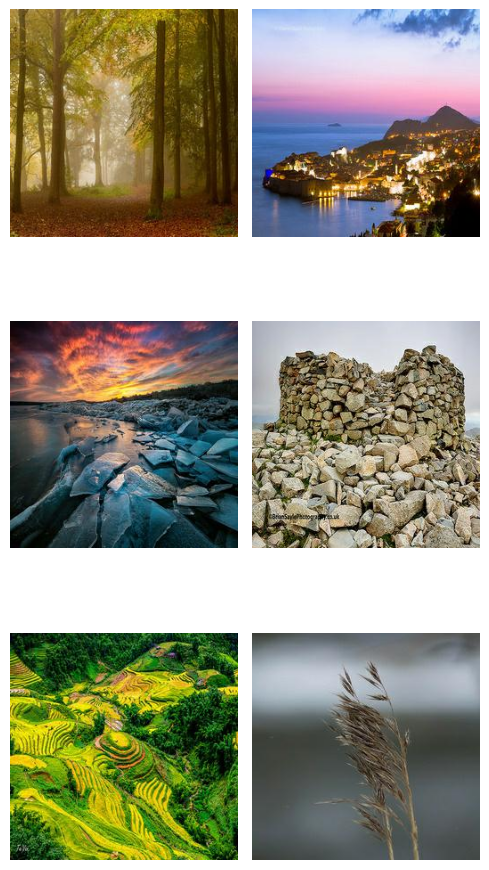

In [14]:
figure, ax = plt.subplots(nrows = 3,ncols = 2,figsize=(5,10))
for i, image_path in enumerate(others_image_paths):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    try:
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    except:
        continue;
        
plt.tight_layout()
plt.show()

And here we have few more other images.

All these images are of shape of 256,256,3 that is height and width of 256 and RGB Channels. With basic EDA we have confirmed that Monet and Other Images are indeed visually distinguishable. Now we will create the CycleGAN model.

## 3. Model Creation

The course didn't provide any reading or other resources for CycleGAN however since it was asked as the assignment we have covered multiple articles, jupyter notebooks like Kaggle Tutorials, and videos to learn how to implement CycleGAN model.

In this part we will create a U-Net Architecture for the CycleGAN. U-Net is a popular deep-learning architecture for semantic segmentation, while it was used first for medical purposes now its used in vide range of applications and is a popular CNN architecture.

We will create downsample and upsample layers for the GycleGAN. In upsample we will use Conv2D transpose layers  to increase the height and width to the target shape and in downsample we wil use stride to reduce the height and width.

We will also be using an instance normalization instead of batch normalizations as many notebooks use this instead of normal BatchNormalization layer. We will also adopt this practice.

In [15]:
image_size = [256, 256]

In [16]:
#These formulas will allow us to read the tfrec files.

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*image_size, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [17]:
#Here we will load the dataset and use Autotune to fetch the batch dataset more efficiently

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls = AUTOTUNE)
    return dataset

In [18]:
monet_df = load_dataset(monet_filenames, labeled=True).batch(1)
photo_df = load_dataset(photo_filenames, labeled=True).batch(1)

Now we will plot the image directly from the batch dataset.

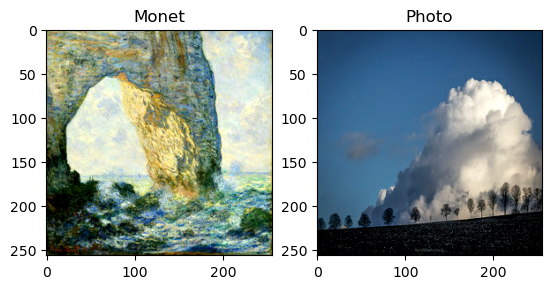

In [19]:
plt.subplot(121)
plt.title('Monet')
plt.imshow(next(iter(monet_df))[0]*0.6 + 0.5)

plt.subplot(122)
plt.title('Photo')
plt.imshow(next(iter(photo_df))[0]*0.6 + 0.5)

Batch is working properly as we can see images loading correctly above. Now we will make the downsample and upsample function. Both of them will output sequential models.

In [20]:
output_channels = 3

#In downsample we will use Conv2D to reduce the size of the image

def downsample(filters, size, instancenorm = True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    model = keras.Sequential()
    model.add(tfl.Conv2D(filters = filters, kernel_size = size, strides = 2, padding='same',
                             kernel_initializer = initializer, use_bias=False))

    if instancenorm:
        model.add(tfa.layers.InstanceNormalization(gamma_initializer = gamma_init))

    model.add(tfl.LeakyReLU())

    return model

In [21]:
# In upsample we will use Conv2DTranspose to increase the size of the image, stride = 2 will 
# increase the dimension by twice

def upsample(filters, size, dropout = False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    model = keras.Sequential()
    model.add(tfl.Conv2DTranspose(filters = filters, kernel_size = size, strides = 2,
                                      padding = 'same',
                                      kernel_initializer = initializer,
                                      use_bias = False))

    model.add(tfa.layers.InstanceNormalization(gamma_initializer = gamma_init))

    if dropout:
        model.add(tfl.Dropout(0.5)) #We tried to change dropout to 0.2 but it was throwing an error

    model.add(tfl.ReLU())

    return model

Now we will create Generator model.

In [22]:
def Generator():
    inputs = tfl.Input(shape=[256,256,3])

    down_stack = [
        downsample(filters = 64, size = 4, instancenorm = False), # Every Downstack layer has stride = 2
        downsample(filters = 128, size = 4),
        downsample(filters = 256, size = 4),
        downsample(filters = 512, size = 4),
        downsample(filters = 512, size = 4),
        downsample(filters = 512, size = 4),
        downsample(filters = 512, size = 4),
        downsample(filters = 512, size = 4),
    ]

    up_stack = [
        upsample(filters = 512, size = 4, dropout = True), # (bs, 2, 2, 1024)
        upsample(filters = 512, size = 4, dropout = True), # (bs, 4, 4, 1024)
        upsample(filters = 512, size = 4, dropout = True), # (bs, 8, 8, 1024)
        upsample(filters = 512, size = 4), # (bs, 16, 16, 1024)
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last_layer = tfl.Conv2DTranspose(output_channels, kernel_size = 4, strides = 2, padding='same',
                                  kernel_initializer = initializer,
                                  activation = 'tanh')

    x = inputs

    # Downsampling through the model
    skips = []
    for down_layer in down_stack:
        x = down_layer(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tfl.Concatenate()([x, skip])

    x = last_layer(x)

    return keras.Model(inputs = inputs, outputs = x)

Now we will create the Discrimintor.

In [23]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    x = tfl.Input(shape=[256, 256, 3])
    
    
    #Down layers are Conv2D layers with their own initializers and leakyReLU activation
    
    down_layer_1 = downsample(filters = 64, size = 4,instancenorm = False)(x)
    down_layer_2 = downsample(filters = 128, size = 4)(down_layer_1)
    down_layer_3 = downsample(filters = 256, size = 4)(down_layer_2) 

    zero_pad1 = tfl.ZeroPadding2D(padding = 2)(down_layer_3)
    conv_layer_1 = tfl.Conv2D(filters = 512, kernel_size = 4, strides = 2,
                         kernel_initializer = initializer, use_bias=False)(zero_pad1)

    norm_1 = tfa.layers.InstanceNormalization(gamma_initializer = gamma_init)(conv_layer_1)

    leaky_relu_1 = tfl.LeakyReLU()(norm_1)

    zero_pad2 = tfl.ZeroPadding2D()(leaky_relu_1)
    
    last_layer = tfl.Conv2D(filters = 1, kernel_size = 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) 

    return keras.Model(inputs = x, outputs = last_layer)

In [24]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

Now we will import the CycleGAN class from the Kaggle Tutorial Notebook, this will apply and train the U-Net Architecture with CycleGAN. 

In [55]:
# The CycleGAN class has been imported from the Kaggle Tutorial notebook
# link: https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook#Build-the-generator

class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

Now we will define our loss functions.

The discriminator loss function below compares real images to a matrix of 1s and fake images to a matrix of 0s. The perfect discriminator will output all 1s for real images and all 0s for fake images. The discriminator loss outputs the average of the real and generated loss.

In [56]:
with strategy.scope():
    def discriminator_loss(real, generated):
        
        cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True, 
                                                           reduction = tf.keras.losses.Reduction.NONE)
        
        # Loss for discriminator includes two parts, first where it tries to flag real image as real
        # Second part where it try to minimize flagging generated images as real
        
        real_loss = cross_entropy(tf.ones_like(real), real)
        fake_loss = cross_entropy(tf.zeros_like(generated), generated)

        total_loss = real_loss + fake_loss

        return total_loss*0.5

The generator aims to fool the discriminator into thinking that the fake generated image is real. The perfect generator will have the discriminator output only 1s. Thus, it compares the generated image to a matrix of 1s to find the loss.

In [57]:
with strategy.scope():
    def generator_loss(generated):
        
        cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True, 
                                                           reduction = tf.keras.losses.Reduction.NONE)
        #For generator we have only one term for loss
        
        return cross_entropy(tf.ones_like(generated), generated)

Since we are using CycleGAN we have to add specific losses for it too. 

We want our original photo and the twice-transformed photo to be similar to one another. Cycle Loss here will be the average of the differences between these images.

In [58]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):

        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
        
        return LAMBDA*loss1

The identity loss below compares the input with the output of the generator.

In [59]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        
        return LAMBDA*0.5*loss

## 4. Model Training and Hyperparameter Tuning

Now we have train the model and perform Hyperparamter Tuning.

We have performed Hyperparameter Tuning Manually for this project. We have tried two different learning rate and beta_1, mainly (0.0001, 0.9) and (0.0002, 0.5). We have chosen (0.0002, 0.5) as optimum parameter as its more stable and a little faster.

We have also tuned the Number of epochs at 5, 10, and 25. We have chosen 25 as the final parameter for our model, epoch for 5 result has been reflected here, please uncomment the code and try for 10 epochs for yourself if you want to validate the results, but it is to be noted that with Kaggle GPU it takes around 50 minutes to train 10 epochs.

In [ ]:
#Hyperparameter Tuning
#Here we manually checked the Learning rate of 0.0001 and beta if 0.9. While it was working okay,
#Learning rate of 0.0002 and beta_1 of 0.5 provided a big faster learning. Please uncomment to try yourself
#It may take hours to try these hyperparamters so please note time left in your environemnt

# with strategy.scope():
    
#     monet_generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9)
#     photo_generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9)

#     monet_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9)
#     photo_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.)

In [61]:
with strategy.scope():
    
    monet_generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5)

In [68]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [63]:
# cycle_gan_model.fit(
#     tf.data.Dataset.zip((monet_df, photo_df)),
#     epochs = 5
# )

Epoch 1/5


2023-08-22 14:28:32.192533: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_8/sequential_80/dropout_12/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 205s 445ms/step - monet_gen_loss: 5.9328 - photo_gen_loss: 6.2534 - monet_disc_loss: 0.5222 - photo_disc_loss: 0.4338
Epoch 2/5
300/300 [==============================] - 134s 445ms/step - monet_gen_loss: 3.9854 - photo_gen_loss: 4.1802 - monet_disc_loss: 0.6457 - photo_disc_loss: 0.5868
Epoch 3/5
300/300 [==============================] - 134s 446ms/step - monet_gen_loss: 3.8424 - photo_gen_loss: 3.9186 - monet_disc_loss: 0.6329 - photo_disc_loss: 0.6220
Epoch 4/5
300/300 [==============================] - 134s 446ms/step - monet_gen_loss: 3.7554 - photo_gen_loss: 3.7886 - monet_disc_loss: 0.6154 - photo_disc_loss: 0.6222
Epoch 5/5
300/300 [==============================] - 134s 446ms/step - monet_gen_loss: 3.6535 - photo_gen_loss: 3.7265 - monet_disc_loss: 0.6178 - photo_disc_loss: 0.6066


In [70]:
#This warning is unnecessary, please ignore as model will train properly.

history_gan = cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_df, photo_df)),
    epochs = 25
)
warnings.simplefilter('ignore')

Epoch 1/25


2023-08-22 14:45:10.996160: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_8/sequential_80/dropout_12/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 160s 445ms/step - monet_gen_loss: 3.5114 - photo_gen_loss: 3.5773 - monet_disc_loss: 0.6126 - photo_disc_loss: 0.6065
Epoch 2/25
300/300 [==============================] - 134s 445ms/step - monet_gen_loss: 3.3920 - photo_gen_loss: 3.5067 - monet_disc_loss: 0.6330 - photo_disc_loss: 0.5950
Epoch 3/25
300/300 [==============================] - 134s 445ms/step - monet_gen_loss: 3.2789 - photo_gen_loss: 3.3901 - monet_disc_loss: 0.6328 - photo_disc_loss: 0.6061
Epoch 4/25
300/300 [==============================] - 134s 445ms/step - monet_gen_loss: 3.2158 - photo_gen_loss: 3.3348 - monet_disc_loss: 0.6296 - photo_disc_loss: 0.6048
Epoch 5/25
300/300 [==============================] - 134s 445ms/step - monet_gen_loss: 3.1651 - photo_gen_loss: 3.2859 - monet_disc_loss: 0.6266 - photo_disc_loss: 0.5985
Epoch 6/25
300/300 [==============================] - 134s 445ms/step - monet_gen_loss: 3.1218 - photo_gen_loss: 3.2222 - monet_disc_loss: 0.6219 - pho

## 5. Model Evaluation

Below are the best results obtained by training different epochs of CycleGAN model:

monet_gen_loss: 2.6568, epoch = 25
photo_gen_loss: 2.7744, epoch = 24
monet_disc_loss: 0.6126, epoch = 1
photo_disc_loss: 0.5985, epoch = 5

From this observation we can state that the Generator is converging at 24/25th Epoch and its performing best at those epochs. However Discriminator has converged much earlier, it has converged around 5th Epoch and is not changing much after this. 

We have chosen 25 Epochs as Parameter to let Generator learn properly, we can do early stopping at 5th or 10th Epoch but it will not train to its optimum level. After 25th Epoch we may get slightly lower generator loss but we also also see an increase in discriminator loss. Reader can try to run it and check themselves in hyperparameter tuning part.

Now we will apply transfer learning to some of the images and observe how CycleGAN is performing.

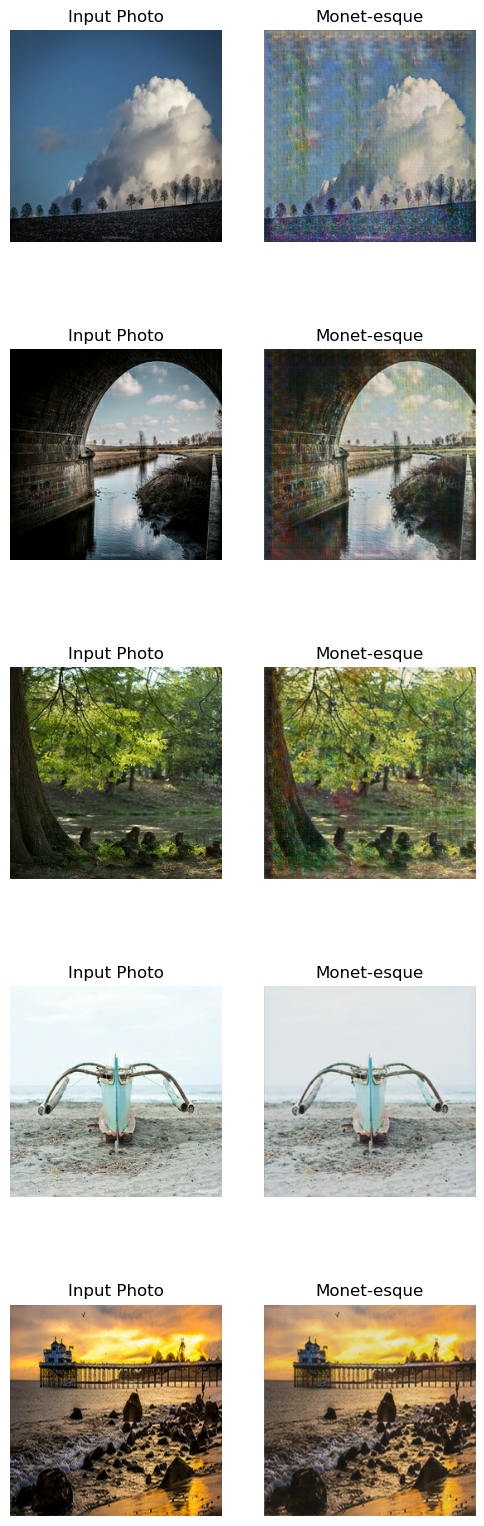

In [79]:
_, ax = plt.subplots(5, 2, figsize=(6, 20))
for i, img in enumerate(photo_df.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

Above we have converted the first 5 images in the batch dataset into Monet versions. And we can observe some issues too. While our model is able to transfer Monet style almost perfectly to the blue skies and even do a good job to green palate forests, it was not able to a good job at all in higher contrast images or images in low contrast as we can see from 4th and 5th image here.

4th Image has a smaller colour gamut overall, and 5th one has wider colour gamut, and it failed in transfering Monet styles to both of them. We can

Before wrapping up the model evaluation we will submit the result and get the MiFID metric, for this project smaller MiFID will indicate better generated images.

In [80]:
import PIL
! mkdir ../images

In [81]:
i = 1
for img in photo_df:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [83]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

We got the score of 59.23486 and are ranked 40 on the leaderboard as of the writing. 

We can try to improve this score by using more complex CNN Architectures and even fine tuning the CycleGAN even more. However as the first attempt to train a CycleGAN and use it for style transfer and creating Monet images out of not monet ones is a surrel experience on its own. This shows the power of AI at even a beginner level and the power of the community as a whole which helped us to learn and practice CycleGAN from the scratch.